## About Dataset
A [dataset](https://www.kaggle.com/datasets/rajgupta2019/qsar-bioconcentration-classes-dataset/data) of manually-curated `BCF` for 779 chemicals was used to determine the mechanisms of **`bioconcentration`**, i.e. to predict whether a chemical: `(1) is mainly stored within lipid tissues`, `(2) has additional storage sites (e.g. proteins)`, or `(3) is metabolized/eliminated`.The file contains the selected Dragon descriptors (9) along with **`CAS`**, **`SMILES`**, **`experimental BCF`**, **`experimental/predicted KOW`** and **`mechanistic class (1, 2, 3)`**. Further details on model development and performance along with descriptor definitions and interpretation are provided in the original manuscript `(Grisoni et al., 2016)`.

### **Dataset Details**

* **SMILES**: The `"Simplified Molecular Input Line Entry System"` **SMILES** is a specification in the form of a line notation for describing the structure of chemical species using short `ASCII` strings. SMILES strings can be imported by most molecule editors for conversion back into two-dimensional drawings or three-dimensional models of the molecules.

* **nHM** : nHM stand for `"number of Heavy Atoms"`

* **iPC09** : iPC09 (short for `"intrinsic potency corrected logP at pH 7.4"`) is a measure of the lipophilicity or hydrophobicity of a molecule in chemistry. It is calculated by correcting the traditional logP (`partition coefficient`) value of a molecule for its intrinsic potency, which takes into account the binding affinity of the molecule to its target receptor. iPC09 is commonly used in drug design and development to predict the pharmacokinetic properties of a compound.

* **PCD** : This stands for `"Polarizability Carbon Descriptor"` and is a measure of the polarizability of carbon atoms in a molecule. It is used to predict the reactivity of a molecule.

* **X2Av**: This is the `"Average Valence Connectivity Index"` and is a measure of the average number of bonds that each atom in a molecule has. It is used to predict the stability and reactivity of a molecule.

* **MLOGP**: This stands for `"Molecular Logarithm of Partition Coefficient"` and is a measure of the lipophilicity or hydrophobicity of a molecule. It is used to predict the ability of a molecule to cross cell membranes and distribute in different tissues.

* **ON1V**: This is the `"Optimized Nitrogen 1st Order Van der Waals Volume"` and is a measure of the size of nitrogen atoms in a molecule. It is used to predict the binding affinity of a molecule to its target receptor.

* **N-072**: This is the `"Negative 0.72 Charged Partial Surface Area"` and is a measure of the electrostatic potential of a molecule. It is used to predict the solubility and permeability of a molecule.

* **B02[C-N]** : This is the `"Burden Eigenvalue B02 for Carbon-Nitrogen Bonds"` and is a measure of the topological complexity of carbon-nitrogen bonds in a molecule. It is used to predict the bioactivity and toxicity of a molecule.

* **F04[C-O]**: This stands for `"Fractional SP3 Carbon Atoms Attached to Oxygen"` and is a measure of the number of carbon atoms in a molecule that are attached to oxygen atoms. It is used to predict the metabolic stability and clearance of a molecule.


## Preparing the tools

In [50]:
# Import all the tools we need

# Regular EDA (exploratory data analysis) and plotting libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
import seaborn as sns
import lazypredict
import rdkit
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem
import mols2grid
%matplotlib inline 

# Models from Scikit-Learn
from lazypredict.Supervised import LazyRegressor
from lazypredict.Supervised import LazyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Model for Evaluations
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import RocCurveDisplay
from yellowbrick.classifier import ROCAUC
from yellowbrick.datasets import load_game

### Load Data

In [51]:
df = pd.read_csv("Grisoni_et_al_2016_EnvInt88.csv")
df.shape

(779, 14)

## Exploratory Data Analysis (EDA)

In [52]:
df.head()

,CAS,SMILES,Set,nHM,piPC09,PCD,X2Av,MLOGP,ON1V,N-072,B02[C-N],F04[C-O],Class,logBCF
0,100-02-7,O=[N+](c1ccc(cc1)O)[O-],Train,0,0.00,1.49,0.14,1.35,0.72,0,1,5,1,0.74
1,100-17-4,O=[N+](c1ccc(cc1)OC)[O-],Train,0,0.00,1.47,0.14,1.70,0.88,0,1,5,1,0.93
2,100-18-5,c1cc(ccc1C(C)C)C(C)C,Train,0,0.00,1.20,0.25,4.14,2.06,0,0,0,3,3.24
3,100-25-4,O=[N+]([O-])c1ccc(cc1)[N+](=O)[O-],Train,0,0.00,1.69,0.13,1.89,0.79,0,1,8,3,-0.40
4,100-40-3,C=CC1CCC=CC1,Train,0,0.00,0.52,0.25,2.65,1.31,0,0,0,1,2.24


In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 779 entries, 0 to 778
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   CAS       779 non-null    object 
 1   SMILES    779 non-null    object 
 2   Set       779 non-null    object 
 3   nHM       779 non-null    int64  
 4   piPC09    779 non-null    float64
 5   PCD       779 non-null    float64
 6   X2Av      779 non-null    float64
 7   MLOGP     779 non-null    float64
 8   ON1V      779 non-null    float64
 9   N-072     779 non-null    int64  
 10  B02[C-N]  779 non-null    int64  
 11  F04[C-O]  779 non-null    int64  
 12  Class     779 non-null    int64  
 13  logBCF    779 non-null    float64
dtypes: float64(6), int64(5), object(3)
memory usage: 85.3+ KB


In [54]:
# Check for any missing values
df.isna().sum()

CAS         0
SMILES      0
Set         0
nHM         0
piPC09      0
PCD         0
X2Av        0
MLOGP       0
ON1V        0
N-072       0
B02[C-N]    0
F04[C-O]    0
Class       0
logBCF      0
dtype: int64

Using the SMILES and rdkit, we will calculate additional parameters such as Molecular Weight and LogP.

In [55]:
def descriptors(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem)
        moldata.append(mol)

    baseData= np.arange(1,1)
    i=0
    for mol in moldata:

        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHAcceptors = Descriptors.NumHAcceptors(mol)
        desc_HeavyAtomCount = Descriptors.HeavyAtomCount(mol)

        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHAcceptors,
                        desc_HeavyAtomCount])

        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1

    columnNames=["MW","LogP","NumHAcceptors","HeavyAtomCount"]
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)

    return descriptors

In [56]:
descriptors(df['SMILES']) 
df = pd.concat([df, descriptors(df['SMILES'])], axis=1)

In [57]:
df.head()

,CAS,SMILES,Set,nHM,piPC09,PCD,X2Av,MLOGP,ON1V,N-072,B02[C-N],F04[C-O],Class,logBCF,MW,LogP,NumHAcceptors,HeavyAtomCount
0,100-02-7,O=[N+](c1ccc(cc1)O)[O-],Train,0,0.00,1.49,0.14,1.35,0.72,0,1,5,1,0.74,139.11,1.30,3.00,10.00
1,100-17-4,O=[N+](c1ccc(cc1)OC)[O-],Train,0,0.00,1.47,0.14,1.70,0.88,0,1,5,1,0.93,153.14,1.60,3.00,11.00
2,100-18-5,c1cc(ccc1C(C)C)C(C)C,Train,0,0.00,1.20,0.25,4.14,2.06,0,0,0,3,3.24,162.28,3.93,0.00,12.00
3,100-25-4,O=[N+]([O-])c1ccc(cc1)[N+](=O)[O-],Train,0,0.00,1.69,0.13,1.89,0.79,0,1,8,3,-0.40,168.11,1.50,4.00,12.00
4,100-40-3,C=CC1CCC=CC1,Train,0,0.00,0.52,0.25,2.65,1.31,0,0,0,1,2.24,108.18,2.53,0.00,8.00


In [58]:
df.describe()

,nHM,piPC09,PCD,X2Av,MLOGP,ON1V,N-072,B02[C-N],F04[C-O],Class,logBCF,MW,LogP,NumHAcceptors,HeavyAtomCount
count,779.00,779.00,779.00,779.00,779.00,779.00,779.00,779.00,779.00,779.00,779.00,779.00,779.00,779.00,779.00
mean,1.75,3.47,1.55,0.24,3.20,1.51,0.19,0.42,3.59,1.74,2.06,249.84,3.50,2.15,15.17
std,1.99,2.98,0.96,0.15,1.60,0.83,0.50,0.49,4.43,0.92,1.35,108.89,1.86,2.02,6.24
min,0.00,0.00,0.00,0.09,-1.96,0.08,0.00,0.00,0.00,1.00,-1.70,68.08,-2.20,0.00,3.00
25%,0.00,0.00,1.21,0.17,2.19,0.91,0.00,0.00,0.00,1.00,0.98,167.55,2.22,1.00,10.00
50%,1.00,4.26,1.40,0.20,3.13,1.27,0.00,0.00,2.00,1.00,2.03,233.10,3.31,2.00,15.00
75%,3.00,6.25,2.29,0.24,4.24,2.02,0.00,1.00,6.00,3.00,2.95,316.01,4.58,4.00,19.00
max,12.00,9.32,5.90,2.23,8.32,7.19,3.00,1.00,25.00,3.00,6.06,959.17,11.10,10.00,55.00


In [59]:
#Choose a style for the plot
plt.style.use("seaborn-v0_8-whitegrid")

# Define a function to plot the selected feature
def plot_feature(feature):
    plt.figure(figsize=(11,6))
    df[feature].hist(bins=15, color='royalblue', edgecolor='black')
    plt.title(f'Distribution of {feature}',fontsize=12)
    plt.xlabel(feature)
    plt.ylabel('Frequency');

# Create a dropdown widget with the dataframe's column names
dropdown = widgets.Dropdown(options=['nHM', 'piPC09', 'PCD', 'X2Av', 'MLOGP', 'ON1V',
       'N-072', 'B02[C-N]', 'F04[C-O]', 'Class', 'logBCF', 'MW', 'LogP',
       'HeavyAtomCount', 'NumHAcceptors'], description='Feature:')

# Use the interact function to create the widget and the plot
widgets.interact(plot_feature, feature=dropdown);

interactive(children=(Dropdown(description='Feature:', options=('nHM', 'piPC09', 'PCD', 'X2Av', 'MLOGP', 'ON1V…

At first glance, there appears to be an imbalance in the classes, which we will address later.

In [60]:
# Visualising Chemicals
smiles_list = df['SMILES'].to_list()
chems = [rdkit.Chem.MolFromSmiles(x) for x in smiles_list]
mols2grid.display(chems)

MolGridWidget()

In [61]:
# Create a function that plots the frequency of different atom types in SMILES
def atom_frequency(smiles_list):

    atom_counts = []
    for smiles in smiles_list:
        # Convert the SMILES string to an RDKit molecule object
        mol = Chem.MolFromSmiles(smiles)
        # Get the atoms in the molecule
        atoms = mol.GetAtoms()
        # Add the symbol for each atom to the atom_counts list
        atom_counts.extend([atom.GetSymbol() for atom in atoms])

    # Create a pandas series with the counts of each atom type
    plot_data = pd.Series(atom_counts).value_counts().sort_index()
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.barplot(x=plot_data.index, y=plot_data.values, color='royalblue', edgecolor='black')
    plt.xlabel('Atom Types')

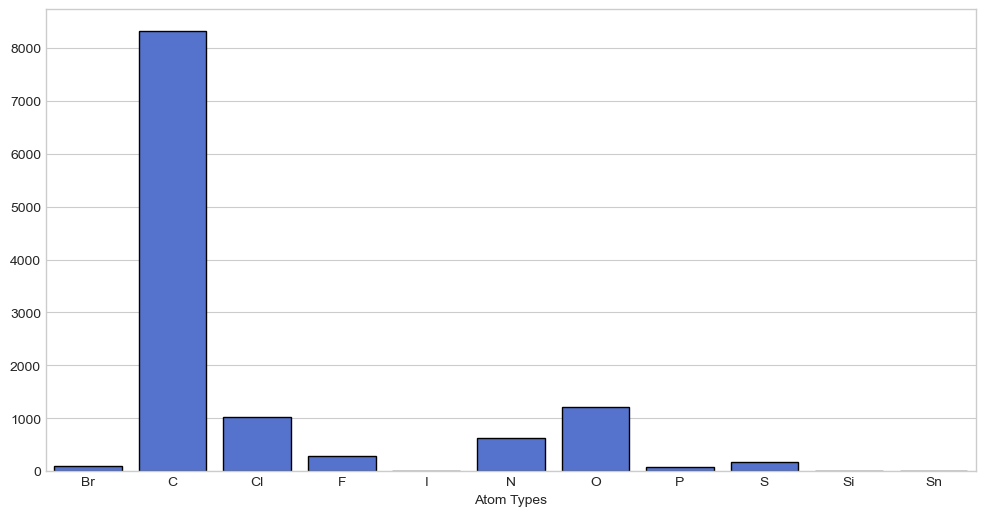

In [62]:
atom_frequency(df['SMILES'])

In [63]:
# Create a function that plots the frequency of various Bond types.
def bond_frequency(smiles_list):
    
    bond_counts = []
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        bonds = mol.GetBonds()
        # Loop through each bond in the molecule and append its bond type to the bond_counts list
        bond_counts.extend([bond.GetBondTypeAsDouble() for bond in bonds])

    # Create a pandas series with the counts of each bond type
    plot_data = pd.Series(bond_counts).value_counts().sort_index()
    palette = ["#ff6f72", "#a4ff53", "#ffa449", "#53f5ff"]
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.barplot(x=plot_data.index, y=plot_data.values, palette=palette, edgecolor='black')
    plt.xlabel('Bond order')

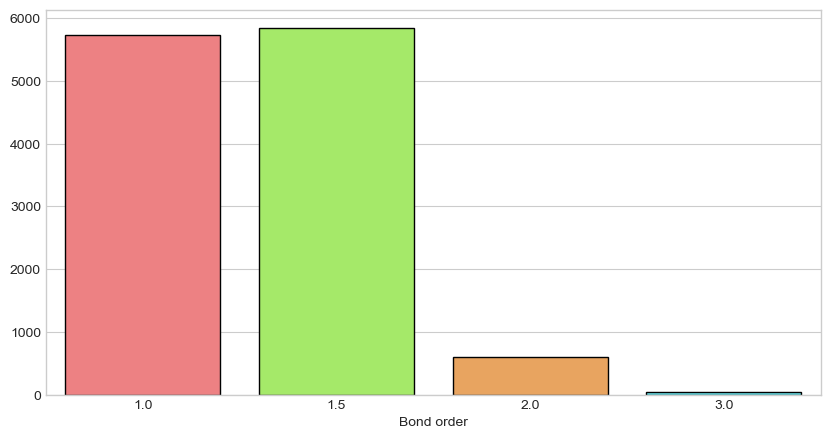

In [64]:
bond_frequency(df['SMILES'])

In [65]:
# Create a function that plots the frequency of different hybridization types in SMILES
def hybridization_frequency(smiles_list):
    
    atom_counts = []
    for smiles in smiles_list:
        # Convert the SMILES string to an RDKit molecule object
        mol = Chem.MolFromSmiles(smiles)
        # Get the atoms in the molecule
        atoms = mol.GetAtoms()
        # Add the symbol for each atom to the atom_counts list
        atom_counts.extend([str(atom.GetHybridization()) for atom in atoms])

    # Create a pandas series with the counts of each hybridization type
    plot_data = pd.Series(atom_counts).value_counts().sort_index()
    palette = ["green", "crimson", "royalblue"]
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.barplot(x=plot_data.index, y=plot_data.values, palette=palette, edgecolor='black')
    plt.xlabel('Hybridization Type')

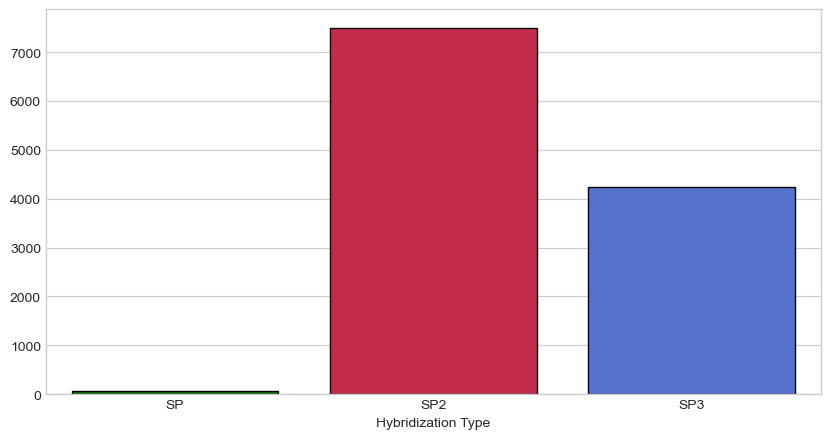

In [66]:
hybridization_frequency(df['SMILES'])

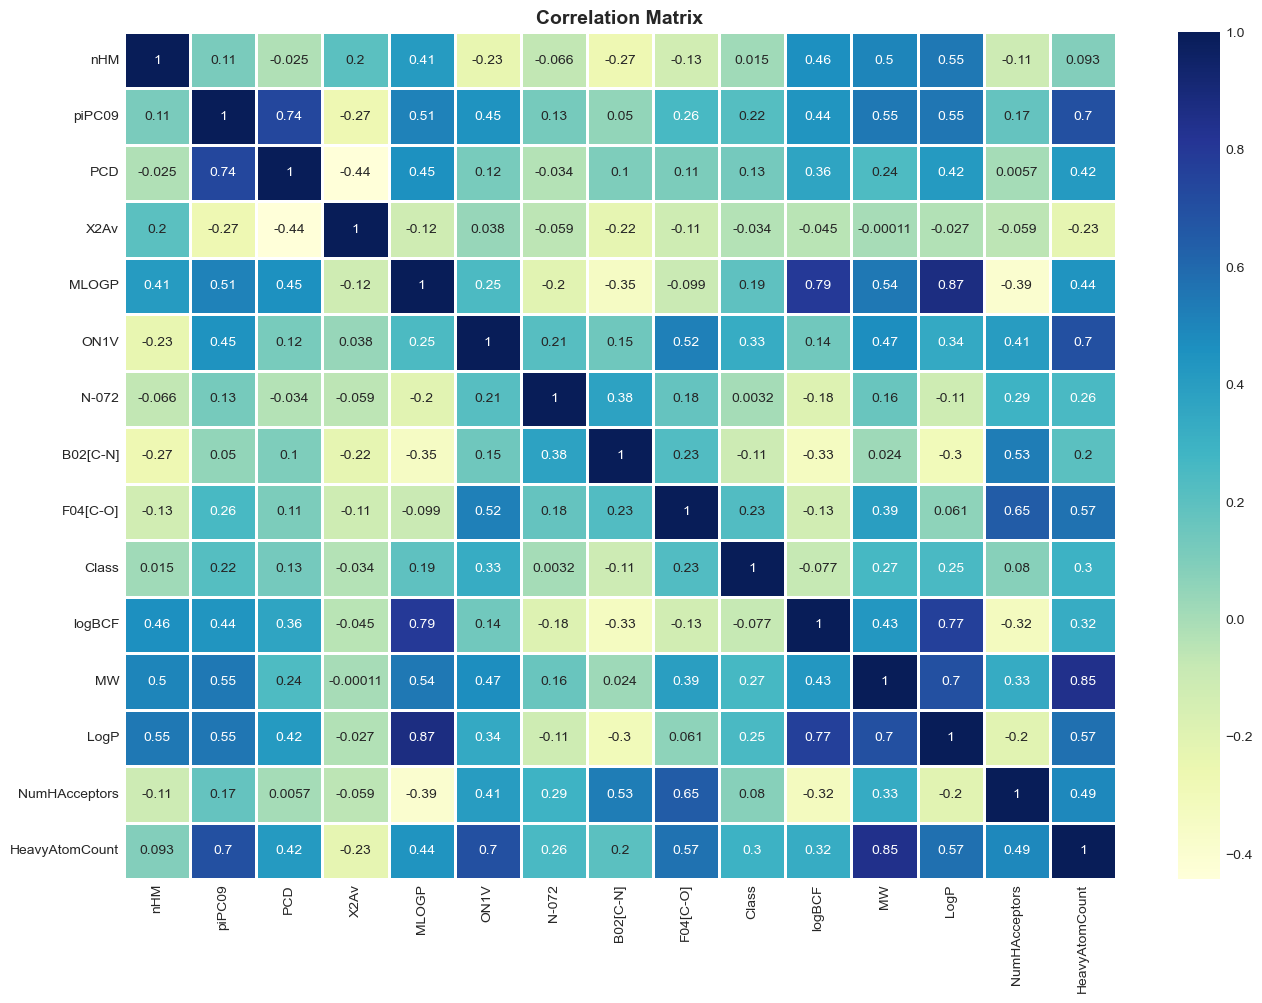

In [67]:
# Making a Correlation Matrix
corr_matrix = df.iloc[:, 3:18].corr()
fig, ax = plt.subplots(figsize=(16, 11))
ax = sns.heatmap(corr_matrix,
                 annot=True, 
                 linewidths=1,
                 cmap="YlGnBu");
plt.title('Correlation Matrix',fontsize=14, fontweight="bold");

## Classification

`Downsampling` the majority class is a useful method for dealing with imbalanced data. In this scenario, we need to decrease the size of classes 1 and 3.

In [68]:
df['Class'].value_counts()

Class
1    460
3    255
2     64
Name: count, dtype: int64

In [69]:
# Shuffle the data
data = df.sample(frac=1, random_state=50)

# Downsampling the classes
class1 = data.loc[data['Class'] == 1][:64]
class2 = data.loc[data['Class'] == 2]
class3 = data.loc[data['Class'] == 3][:64]

# Combine the new downsampled classes
normal_distributed_df = pd.concat([class1, class2, class3])

# Shuffle the data
new_df = normal_distributed_df.sample(frac=1, random_state=50)

In [70]:
new_df.head()

,CAS,SMILES,Set,nHM,piPC09,PCD,X2Av,MLOGP,ON1V,N-072,B02[C-N],F04[C-O],Class,logBCF,MW,LogP,NumHAcceptors,HeavyAtomCount
284,2498-66-0,O=C1c2c(ccc3c2cccc3)C(=O)c2c1cccc2,Train,0,8.03,3.81,0.15,3.73,1.86,0,0,11,3,1.63,258.28,3.62,2.00,20.00
573,69806-40-2/72619-32-0,O=C(OC)C(Oc2ccc(Oc1ncc(cc1Cl)C(F)(F)F)cc2)C,Test,1,6.50,2.31,0.14,3.41,2.04,0,1,6,3,1.23,375.73,4.49,5.00,25.00
512,608-93-5,Clc1c(c(cc(c1Cl)Cl)Cl)Cl,Train,5,0.00,1.26,0.23,4.93,0.60,0,0,0,1,3.84,250.34,4.95,0.00,11.00
144,128-37-0,Oc1c(cc(cc1C(C)(C)C)C)C(C)(C)C,Train,0,0.00,1.24,0.26,4.18,2.38,0,0,7,3,3.12,220.36,4.30,1.00,16.00
775,99387-89-0,FC(F)(F)c2cc(ccc2(N=C(n1cncc1)COCCC))Cl,Test,1,6.56,2.37,0.16,3.77,2.28,0,1,3,2,2.59,345.75,4.56,4.00,23.00


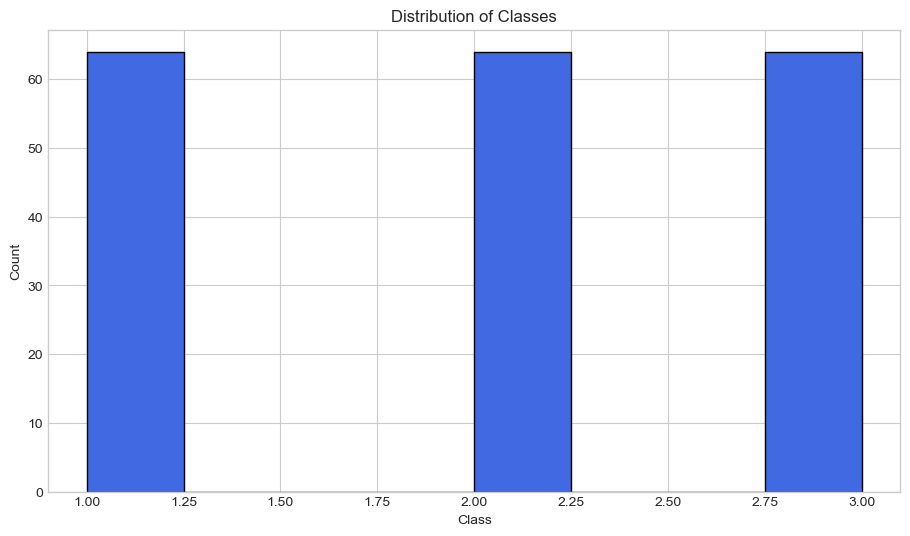

In [71]:
#Choose a style for the plot
plt.style.use("seaborn-v0_8-whitegrid")

# Visualize classes
plt.figure(figsize=(11,6))
new_df["Class"].hist(bins=8, color='royalblue', edgecolor='black')
plt.title('Distribution of Classes',fontsize=12)
plt.xlabel('Class')
plt.ylabel('Count');

After balancing the classes, we can proceed with trying different classification models 

In [72]:
# Spliting data into X and y
X = new_df.drop(['Class', 'CAS', 'SMILES', 'Set', 'logBCF'],axis=1)
y = new_df['Class']

In [73]:
# Setup random seed
np.random.seed(50)

# Split data into train & test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Comparing Classification Models

In [74]:
# Setup random seed
np.random.seed(50)

# Using lazypredict to run through different models
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 30.69it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000063 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 361
[LightGBM] [Info] Number of data points in the train set: 153, number of used features: 13
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.118415
[LightGBM] [Info] Start training from score -1.079194
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

In [75]:
models

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LogisticRegression,0.62,0.62,None,0.61,0.02
ExtraTreesClassifier,0.62,0.62,None,0.62,0.16
LinearSVC,0.59,0.60,None,0.59,0.03
CalibratedClassifierCV,0.59,0.60,None,0.59,0.05
RidgeClassifierCV,0.59,0.60,None,0.59,0.02
NuSVC,0.56,0.57,None,0.57,0.02
ExtraTreeClassifier,0.56,0.56,None,0.56,0.02
SVC,0.54,0.55,None,0.53,0.02
RidgeClassifier,0.54,0.54,None,0.53,0.01


`Lazypredict` gives us a basic idea of how different models perform without hyperparameter tuning. With this in mind, we will experiment with some of the models to see if we can improve them using **`GridSearchCV`**.

### Hyperparameter tuning with GridSearchCV

In [76]:
# Setup random seed
np.random.seed(50)

et = ExtraTreesClassifier()
et.fit(X_train, y_train)

y_preds = et.predict(X_test)
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           1       0.50      0.46      0.48        13
           2       0.60      0.43      0.50        14
           3       0.53      0.75      0.62        12

    accuracy                           0.54        39
   macro avg       0.54      0.55      0.53        39
weighted avg       0.54      0.54      0.53        39



In [77]:
# Create a hyperparameter grid for ExtraTreesClassifier
et_grid = {"max_depth": [5, 8, 9, None], 
             "max_features": [3, 5, 7], 
             "n_estimators": [200, 300, 400]}

# Setup random seed
np.random.seed(50)

# Setup GridSearchCV for ExtraTreesClassifier
gs_et = GridSearchCV(ExtraTreesClassifier(), 
                           param_grid=et_grid,
                           cv=5,
                           verbose=True,
                           n_jobs = -1)

# Fit GridSearchCV for ExtraTreesClassifier
gs_et.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5, estimator=ExtraTreesClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 8, 9, None],
                         'max_features': [3, 5, 7],
                         'n_estimators': [200, 300, 400]},
             verbose=True)

In [78]:
y_preds = gs_et.predict(X_test)
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           1       0.47      0.69      0.56        13
           2       1.00      0.36      0.53        14
           3       0.53      0.67      0.59        12

    accuracy                           0.56        39
   macro avg       0.67      0.57      0.56        39
weighted avg       0.68      0.56      0.56        39



In [79]:
# Setup random seed
np.random.seed(50)

log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

y_preds = log_reg.predict(X_test)
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           1       0.42      0.38      0.40        13
           2       0.58      0.50      0.54        14
           3       0.53      0.67      0.59        12

    accuracy                           0.51        39
   macro avg       0.51      0.52      0.51        39
weighted avg       0.51      0.51      0.51        39



In [80]:
# Create a hyperparameter grid for LogisticRegression
log_reg_grid = {"C": np.logspace(-10, 10, 30),
                "solver": ["liblinear","newton-cg", "saga"],
                "max_iter": [100, 700, 1000, 2000, 3000]}

# Setup random seed
np.random.seed(50)

# Setup GridSearchCV for LogisticRegression
gs_log_reg = GridSearchCV(LogisticRegression(),
                          param_grid=log_reg_grid,
                          cv=5,
                          verbose=True,
                          n_jobs = -1)

# Fit GridSearchCV for LogisticRegression
gs_log_reg.fit(X_train, y_train);
y_preds = gs_log_reg.predict(X_test);

Fitting 5 folds for each of 450 candidates, totalling 2250 fits


In [81]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           1       0.60      0.69      0.64        13
           2       0.88      0.50      0.64        14
           3       0.56      0.75      0.64        12

    accuracy                           0.64        39
   macro avg       0.68      0.65      0.64        39
weighted avg       0.69      0.64      0.64        39



In [82]:
gs_log_reg.best_params_

{'C': 0.09236708571873885, 'max_iter': 100, 'solver': 'newton-cg'}

Okay, so we were able to improve `LogisticRegression` a little bit. Of course, we can try changing hyperparameters till the sun explodes, but it's highly unlikely that there would be major improvement in performance.

### Confusion matrix , ROC Curves and Feature Importance

In [83]:
# Setup random seed
np.random.seed(50)

log_reg = LogisticRegression(C=0.09236708571873885, max_iter=100, solver='newton-cg')
log_reg.fit(X_train, y_train)

y_preds = log_reg.predict(X_test)
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           1       0.60      0.69      0.64        13
           2       0.88      0.50      0.64        14
           3       0.56      0.75      0.64        12

    accuracy                           0.64        39
   macro avg       0.68      0.65      0.64        39
weighted avg       0.69      0.64      0.64        39



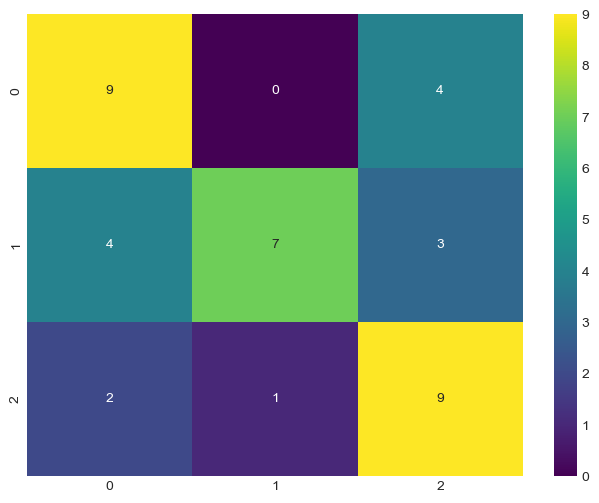

In [84]:
# Making a Confusion Matrix
ConfusionMatrix = confusion_matrix(y_test, y_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(ConfusionMatrix, cmap="viridis", annot=True);

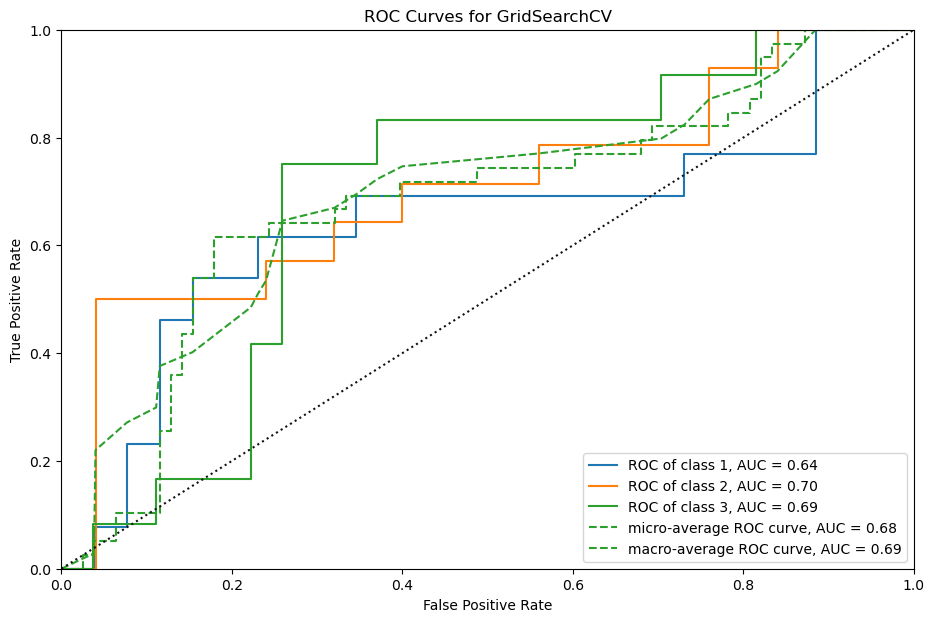

In [85]:
#Choose a style for the plot
plt.style.use("default")

# Ploting Multi-class ROC Curves
plt.figure(figsize=(11,7))
visualizer = ROCAUC(gs_log_reg)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show();

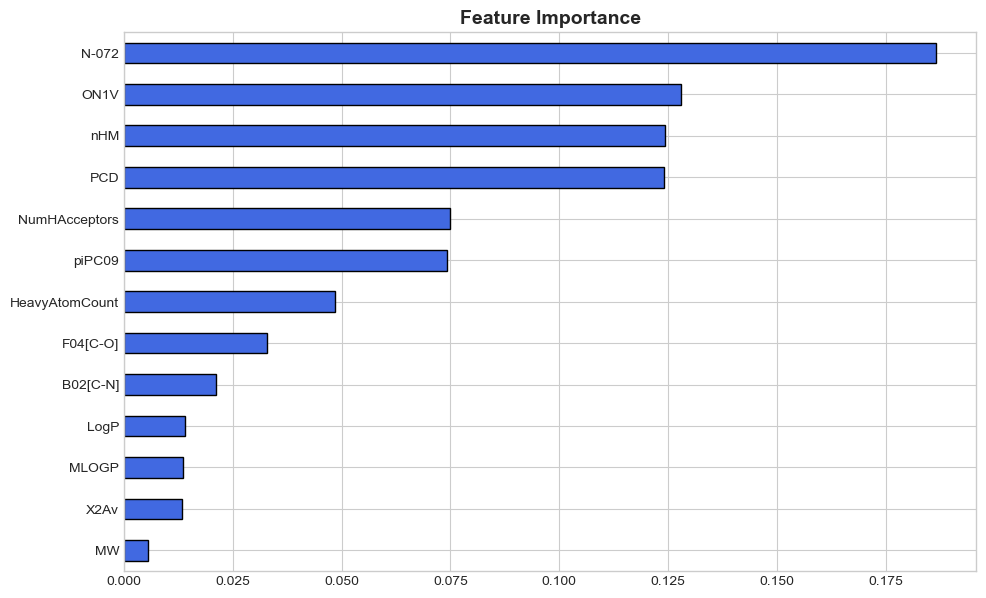

In [86]:
#Choose a style for the plot
plt.style.use("seaborn-v0_8-whitegrid")

# Visualize feature importance
feature_scores = pd.Series(np.abs(log_reg.coef_[0]), index=X_train.columns).sort_values(ascending=True)
plt.figure(figsize=(11, 7))
plt.title("Feature Importance", fontsize=14, fontweight="bold")
feature_scores.plot(x='Feature', y='Importance', kind='barh', color='royalblue', edgecolor='black');

## Regression

For the regression part, we will use the original data and not the downsampled one

In [87]:
# Spliting data into X and y
X = df.drop(['Class', 'CAS', 'SMILES', 'Set', 'logBCF'],axis=1)
y = df['logBCF']

In [88]:
# Setup random seed
np.random.seed(50)

# Split data into train & test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Comparing Regression Models

In [89]:
# Setup random seed
np.random.seed(50)

# Using lazypredict to run through different models
reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

 24%|███████████████████▌                                                              | 10/42 [00:00<00:03, 10.34it/s]

GammaRegressor model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.


 79%|████████████████████████████████████████████████████████████████▍                 | 33/42 [00:02<00:00, 17.82it/s]

PoissonRegressor model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfPoissonLoss'.
QuantileRegressor model failed to execute
Solver interior-point is not anymore available in SciPy >= 1.11.0.


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:03<00:00, 11.49it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1099
[LightGBM] [Info] Number of data points in the train set: 623, number of used features: 13
[LightGBM] [Info] Start training from score 2.049262
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

In [90]:
models

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
ExtraTreesRegressor,0.71,0.74,0.71,0.49
NuSVR,0.70,0.73,0.72,0.05
SVR,0.69,0.72,0.73,0.05
GradientBoostingRegressor,0.69,0.71,0.74,0.29
LGBMRegressor,0.68,0.71,0.75,0.07
HistGradientBoostingRegressor,0.67,0.70,0.75,0.39
AdaBoostRegressor,0.67,0.70,0.75,0.14
RandomForestRegressor,0.66,0.69,0.77,0.92
XGBRegressor,0.65,0.68,0.78,0.12


Lets try to tune hyperparameters for some of the models.

### Hyperparameter tuning with GridSearchCV

In [91]:
## Create a functions to evaluate the models
def r2_adj(model,X,y):
    r2 = model.score(X,y)
    n = X.shape[0]
    p = X.shape[1]
    return 1-(1-r2)*(n-1)/(n-p-1)

def evaluate_preds(model,X, y, y_true, y_preds):
    
    R2 = r2_score(y_true, y_preds)
    adj_r2 = r2_adj(model,X, y)
    RMSE = mean_squared_error(y_true, y_preds, squared=False)
    
    metric_dict = {"R2": round(R2, 2),
                   "Adjusted R-Squared	": round(adj_r2, 2),
                   "RMSE": round(RMSE, 2)}
    
    print(f"R2 score: {R2:.2f}")
    print(f"Adjusted R-Squared: {adj_r2:.2f}")
    print(f"RMSE: {RMSE:.2f}")
    
    return metric_dict

In [92]:
# Setup random seed
np.random.seed(50)

et_reg = ExtraTreesRegressor(n_estimators=100, random_state=0)
et_reg.fit(X_train, y_train)
y_preds = et_reg.predict(X_test)
evaluate_preds(et_reg,X_test, y_test,y_test,y_preds);

R2 score: 0.73
Adjusted R-Squared: 0.71
RMSE: 0.71


In [93]:
# Create a hyperparameter grid for ExtraTreesRegressor
et_reg_grid = {'n_estimators': [10,50,100,500],
    'max_depth': [2,8,16,30,50],
    'oob_score': [True, False],
    'max_features': [None,3,7],    
    'bootstrap': [True, False],
    'warm_start': [True, False]}

# Setup random seed
np.random.seed(50)

# Setup GridSearchCV for ExtraTreesRegressor
gs_et_reg = GridSearchCV(ExtraTreesRegressor(),
                          param_grid=et_reg_grid,
                          cv=5,
                          verbose=True,
                          n_jobs = -1)

# Fit GridSearchCV for ExtraTreesRegressor
gs_et_reg.fit(X_train, y_train);
y_preds = gs_et_reg.predict(X_test);
evaluate_preds(gs_et_reg,X_test, y_test,y_test,y_preds);

Fitting 5 folds for each of 480 candidates, totalling 2400 fits
R2 score: 0.73
Adjusted R-Squared: 0.71
RMSE: 0.71


In [94]:
# Setup random seed
np.random.seed(50)

GBR = GradientBoostingRegressor()
GBR.fit(X_train, y_train)
y_preds = GBR.predict(X_test)
evaluate_preds(GBR,X_test,y_test,y_test,y_preds);

R2 score: 0.72
Adjusted R-Squared: 0.69
RMSE: 0.73


In [95]:
# Create a hyperparameter grid for GradientBoostingRegressor
GBR_grid = {'n_estimators':[50,100,500], 
            'learning_rate': [0.1,0.05,0.02],
            'max_depth':[None,4,7,10], 
            'min_samples_leaf':[3], 
            'max_features':[1,3,7]} 


# Setup random seed
np.random.seed(50)

# Setup GridSearchCV for GradientBoostingRegressor
gs_GBR = GridSearchCV(GradientBoostingRegressor(),
                          param_grid=GBR_grid,
                          cv=5,
                          verbose=True,
                          n_jobs = -1)

# Fit GridSearchCV for GradientBoostingRegressor
gs_GBR.fit(X_train, y_train);
y_preds = gs_GBR.predict(X_test);
evaluate_preds(gs_GBR,X_test, y_test,y_test,y_preds);

Fitting 5 folds for each of 108 candidates, totalling 540 fits
R2 score: 0.72
Adjusted R-Squared: 0.69
RMSE: 0.73


Okay, this will do. Finally, let's build a model using these hyperparameters and check the Feature Importance.

In [96]:
gs_GBR.best_params_

{'learning_rate': 0.1,
 'max_depth': 4,
 'max_features': 7,
 'min_samples_leaf': 3,
 'n_estimators': 100}

In [97]:
# Setup random seed
np.random.seed(50)

GBR = GradientBoostingRegressor(learning_rate = 0.02, max_depth = 4, max_features = 3, min_samples_leaf = 3, n_estimators = 500)
GBR.fit(X_train, y_train)
y_preds = GBR.predict(X_test)
evaluate_preds(GBR,X_test,y_test,y_test,y_preds);

R2 score: 0.74
Adjusted R-Squared: 0.72
RMSE: 0.70


### Feature Importance

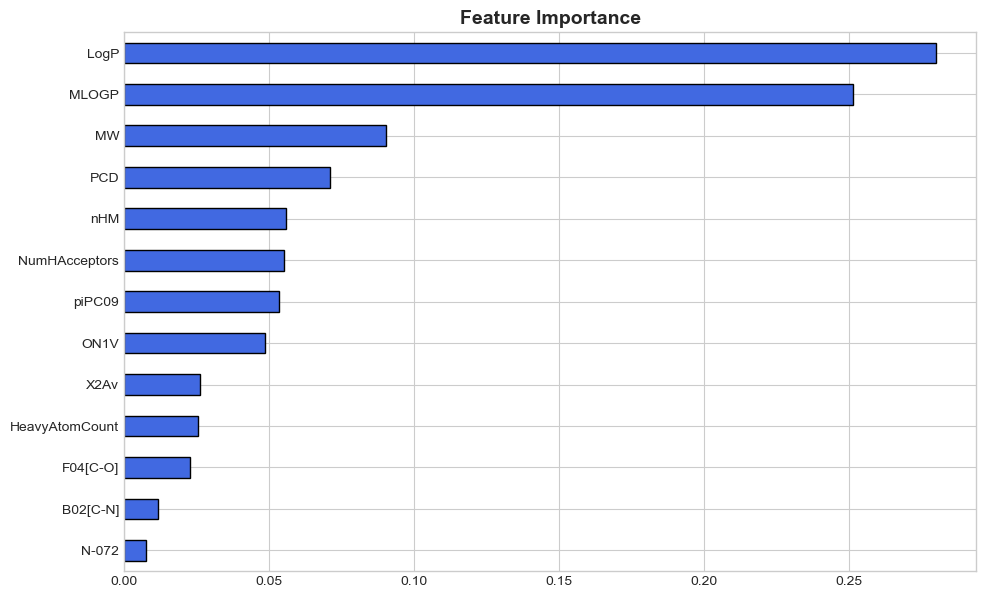

In [98]:
#Choose a style for the plot
plt.style.use("seaborn-v0_8-whitegrid")

# Visualize feature importance
feature_scores = pd.Series(GBR.feature_importances_, index=X_train.columns).sort_values(ascending=True)
plt.figure(figsize=(11, 7))
plt.title("Feature Importance", fontsize=14, fontweight="bold")
feature_scores.plot(x='Feature', y='Importance', kind='barh', color='royalblue', edgecolor='black');